### Improving baseline model

There are 5 key stages that encompass the model improvement:

- **Stage 1: Preparing MLflow environment** - Preparation and launch of Mlflow services in the form of *shell*-script (outside of the notebook): basis for working with experiments and logging the models results.

- **Stage 2: Exploratory Data Analysis (EDA)** - Conducting a thorough data analysis for understanding their structure and peculiarities.

- **Stage 3: Feature Engineering and Model Training** - Generating new features and training the model on them after conducting EDA.

- **Stage 4: Feature Selection and Model Training** - Selecting the most important features and training the model again for model quality improvement.

- **Stage 5: Hyperparameter Tuning and Model Training** - Optimization of hyperparameters.

At the beginning of the analysis, we will import the rquired packages and load the data from the database which will be the basis of the model improvements and its subsequest training:

In [40]:
# Standard library imports
import json
import os
import warnings
from collections import defaultdict

# Third-party libraries imports
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import psycopg2 as psycopg
import seaborn as sns
from autofeat import AutoFeatRegressor
from catboost import CatBoostRegressor
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from optuna.integration.mlflow import MLflowCallback
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    cross_validate, 
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    KBinsDiscretizer,
    PolynomialFeatures, 
    RobustScaler,
)
from sklearn.compose import ColumnTransformer

# Constants
TABLE_NAME = "flats_clean"
INDEX_COL = "flat_id"
COLS_TO_DROP = ["id", "build_year"]
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Mlflow constants
EXPERIMENT_NAME = 'PROJECT_SPRINT_2'
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

# Tweaking additional settings
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
sns.set_theme(style="ticks", palette="pastel")
warnings.filterwarnings("ignore")

In [2]:
# Setting DB connection parameters
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
connection.update(postgres_credentials)

# Establishing Postgres DB connection
with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

# Transforming extracted data to DataFrame
df = pd.DataFrame(data, columns=columns)
df.set_index(INDEX_COL, inplace=True)
df.drop(COLS_TO_DROP, axis=1, inplace=True)
df.head(3)

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price
flat_id,,,,,,,,,,,,,,,
130624,4,55.693623,37.593281,2.64,360,16,True,5,12.00,33.799999,2,False,False,57.799999,19777000
130625,4,55.871330,37.664104,2.70,191,12,True,12,6.68,36.849998,2,False,False,45.810001,11500000
130626,1,55.813946,37.599911,3.00,223,7,True,6,10.00,34.000000,2,False,False,58.000000,12750000


We have managed to load `flats_clean` table into the pandas DataFrame which contains the already preprocessed data which we have obtained at the previous project. Let's split the data in the following way:

* Training set
* Test set.

It will enable us to not only have the hold-out set for testing the models but also conduct cross-validation on the splits of the training data.

In [3]:
# Separating features from target
target = df["price"]
features = df.drop("price", axis=1)

# Splitting data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

# Displaying split data information
print("Full data dimensions: {}".format(features.shape))
print("Training data dimensions: {}".format(features_train.shape))
print("Test data dimensions: {}".format(features_test.shape))

Full data dimensions: (97178, 14)
Training data dimensions: (72883, 14)
Test data dimensions: (24295, 14)


#### Stage 2: Exploratory Data Analysis (EDA)

##### Basic data analysis

We will firstly take a look at the data: considering a concise summary of the dataset, its data types and making sure there are no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97178 entries, 130624 to 130623
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   building_type_int  97178 non-null  int64  
 1   latitude           97178 non-null  float64
 2   longitude          97178 non-null  float64
 3   ceiling_height     97178 non-null  float64
 4   flats_count        97178 non-null  int64  
 5   floors_total       97178 non-null  int64  
 6   has_elevator       97178 non-null  bool   
 7   floor              97178 non-null  int64  
 8   kitchen_area       97178 non-null  float64
 9   living_area        97178 non-null  float64
 10  rooms              97178 non-null  int64  
 11  is_apartment       97178 non-null  bool   
 12  studio             97178 non-null  bool   
 13  total_area         97178 non-null  float64
 14  price              97178 non-null  int64  
dtypes: bool(3), float64(6), int64(6)
memory usage: 9.9 MB


We can see that the cleaned data represent a base of 97.178 real estate objects where each one has been assigned with a price for training the price prediction model. Number of *non-null* values in each of the columns is equal to the total number of objects in the DataFrame which indicates the absence of missing values. Let's check this:

In [5]:
df.isnull().sum().sort_values(ascending=False)

building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
dtype: int64

Lastly, we will consider the data types which are present in the columns:

In [6]:
df.dtypes

building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
floor                  int64
kitchen_area         float64
living_area          float64
rooms                  int64
is_apartment            bool
studio                  bool
total_area           float64
price                  int64
dtype: object

Data is predominantly represented by integer anb float data types as well as (to a much lesser extent) binary type.

##### Features analysis for a model

The next step is to explore features that will be later taking part in the modeling process. Let's display the first row of the DataFrame in order to have one example represented by one real estate object:

In [7]:
features.head(1)

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area
flat_id,,,,,,,,,,,,,,
130624,4,55.693623,37.593281,2.64,360,16,True,5,12.0,33.799999,2,False,False,57.799999


We can now start considering the features from different angles. Let's take a look at the total area depending on the building types with an additional filtering by rooms number in a flat:

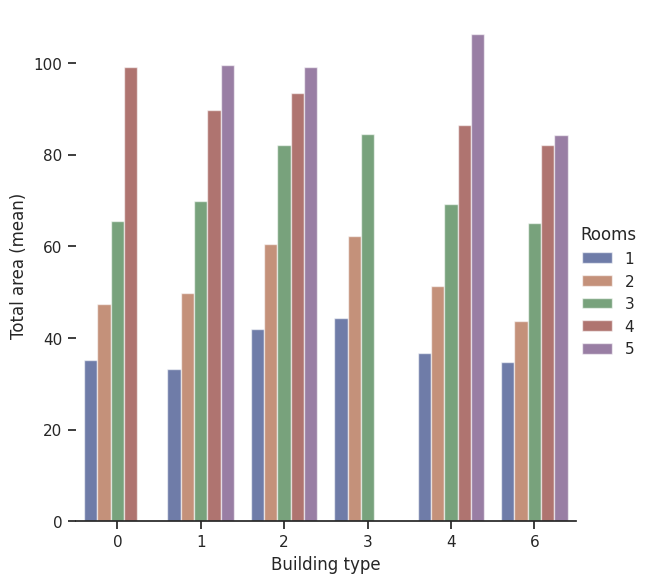

In [8]:
cat_plot = sns.catplot(
    data=features, kind="bar", x="building_type_int", 
    y="total_area", hue="rooms", errorbar=None, 
    palette='dark', alpha=.6, height=6,
)
cat_plot.despine(left=True)
cat_plot.set_axis_labels("Building type", "Total area (mean)")
cat_plot.legend.set_title("Rooms")

We can notice on the above graph that as the number of rooms increases, the total area on average goes up as well which makes sense. Hence, we have made sure that the chosen data split is correct and does not have contradictory or anomalous information. Some buildings can be characterized by the fact that they do not have flats with 4 or 5 rooms (at least we do not have some other data to argue otherwise). We can especially note here buildings of types 1, 2 and 4 where the largest average areas are specific for flats with 5 rooms.

Now we can look at how ceiling heights are distributed depending upon rooms number. We will also highlight the flats considered to be apartments:

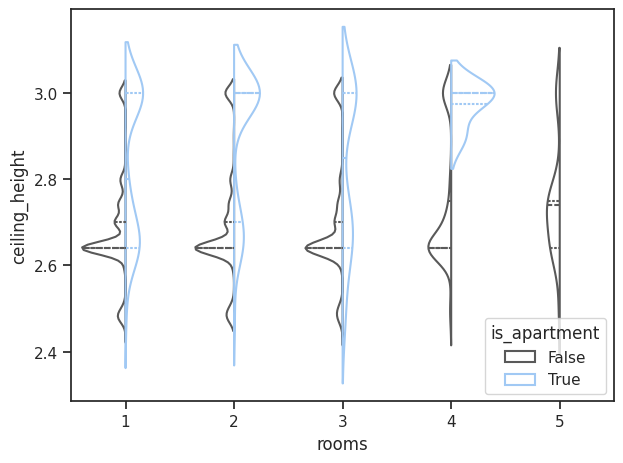

In [9]:
violin_plot = sns.violinplot(
    data=features, x="rooms", y="ceiling_height", 
    hue="is_apartment", split=True, inner="quart", 
    fill=False, palette={True: "b", False: ".35"},
)
plt.tight_layout()
plt.show()

Regarding flats with 1-3 rooms (not apartments), a majority of ceiling heights are around 2.6 meters and there are quite a lot of such flats. However, as the number of rooms for such flats increases, ceiling data become more diverse which can be seen from the change of the bell-shaped curve to a flatter one.

As far as apartments are concerned, ceiling heights distributions are characterized by bimodal curves where for flats withg 1-3 rooms the height varies from 2.6 meters to 3.0 meters. Heights for 4-room flats revolve around 3.0 meters.

Next, we can consider data from a statistical point of view: by building a correlation matrix of features in the form of a heatmap:

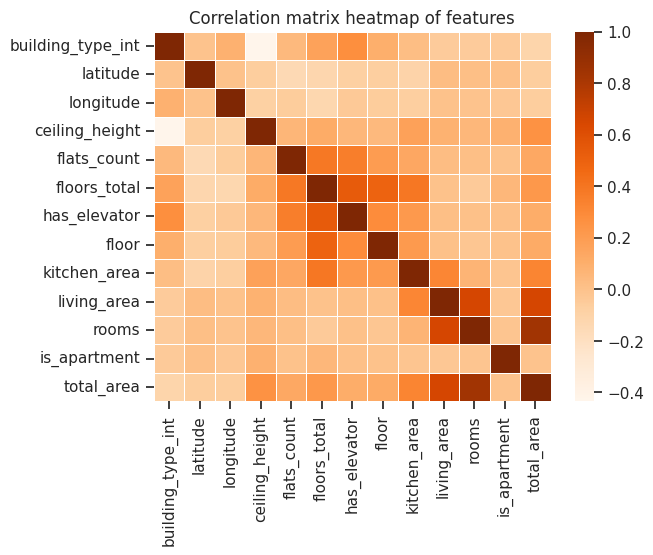

rooms             0.840200
living_area       0.655385
kitchen_area      0.325897
ceiling_height    0.257057
floors_total      0.225729
Name: total_area, dtype: float64

In [38]:
corr_matrix = features.drop('studio', axis=1).corr()
corr_heatmap = sns.heatmap(
        corr_matrix, 
        linewidth=.5,
        cmap='Oranges',
    )
corr_heatmap.xaxis.tick_bottom()
corr_heatmap.yaxis.tick_left()
corr_heatmap.set(title="Correlation matrix heatmap of features")
plt.show()

corr_total_area_5 = corr_matrix["total_area"].abs().sort_values(ascending=False)[1:].head()
display(corr_total_area_5)

Heatmap as well as the highest correlation values (in absolute value) we can see that the total area is affected by the room number, kitchen/living room areas, ceiling height and number of floors.

We can also consider the binary and other columns separately. Let's build histograms for integer and float columns:

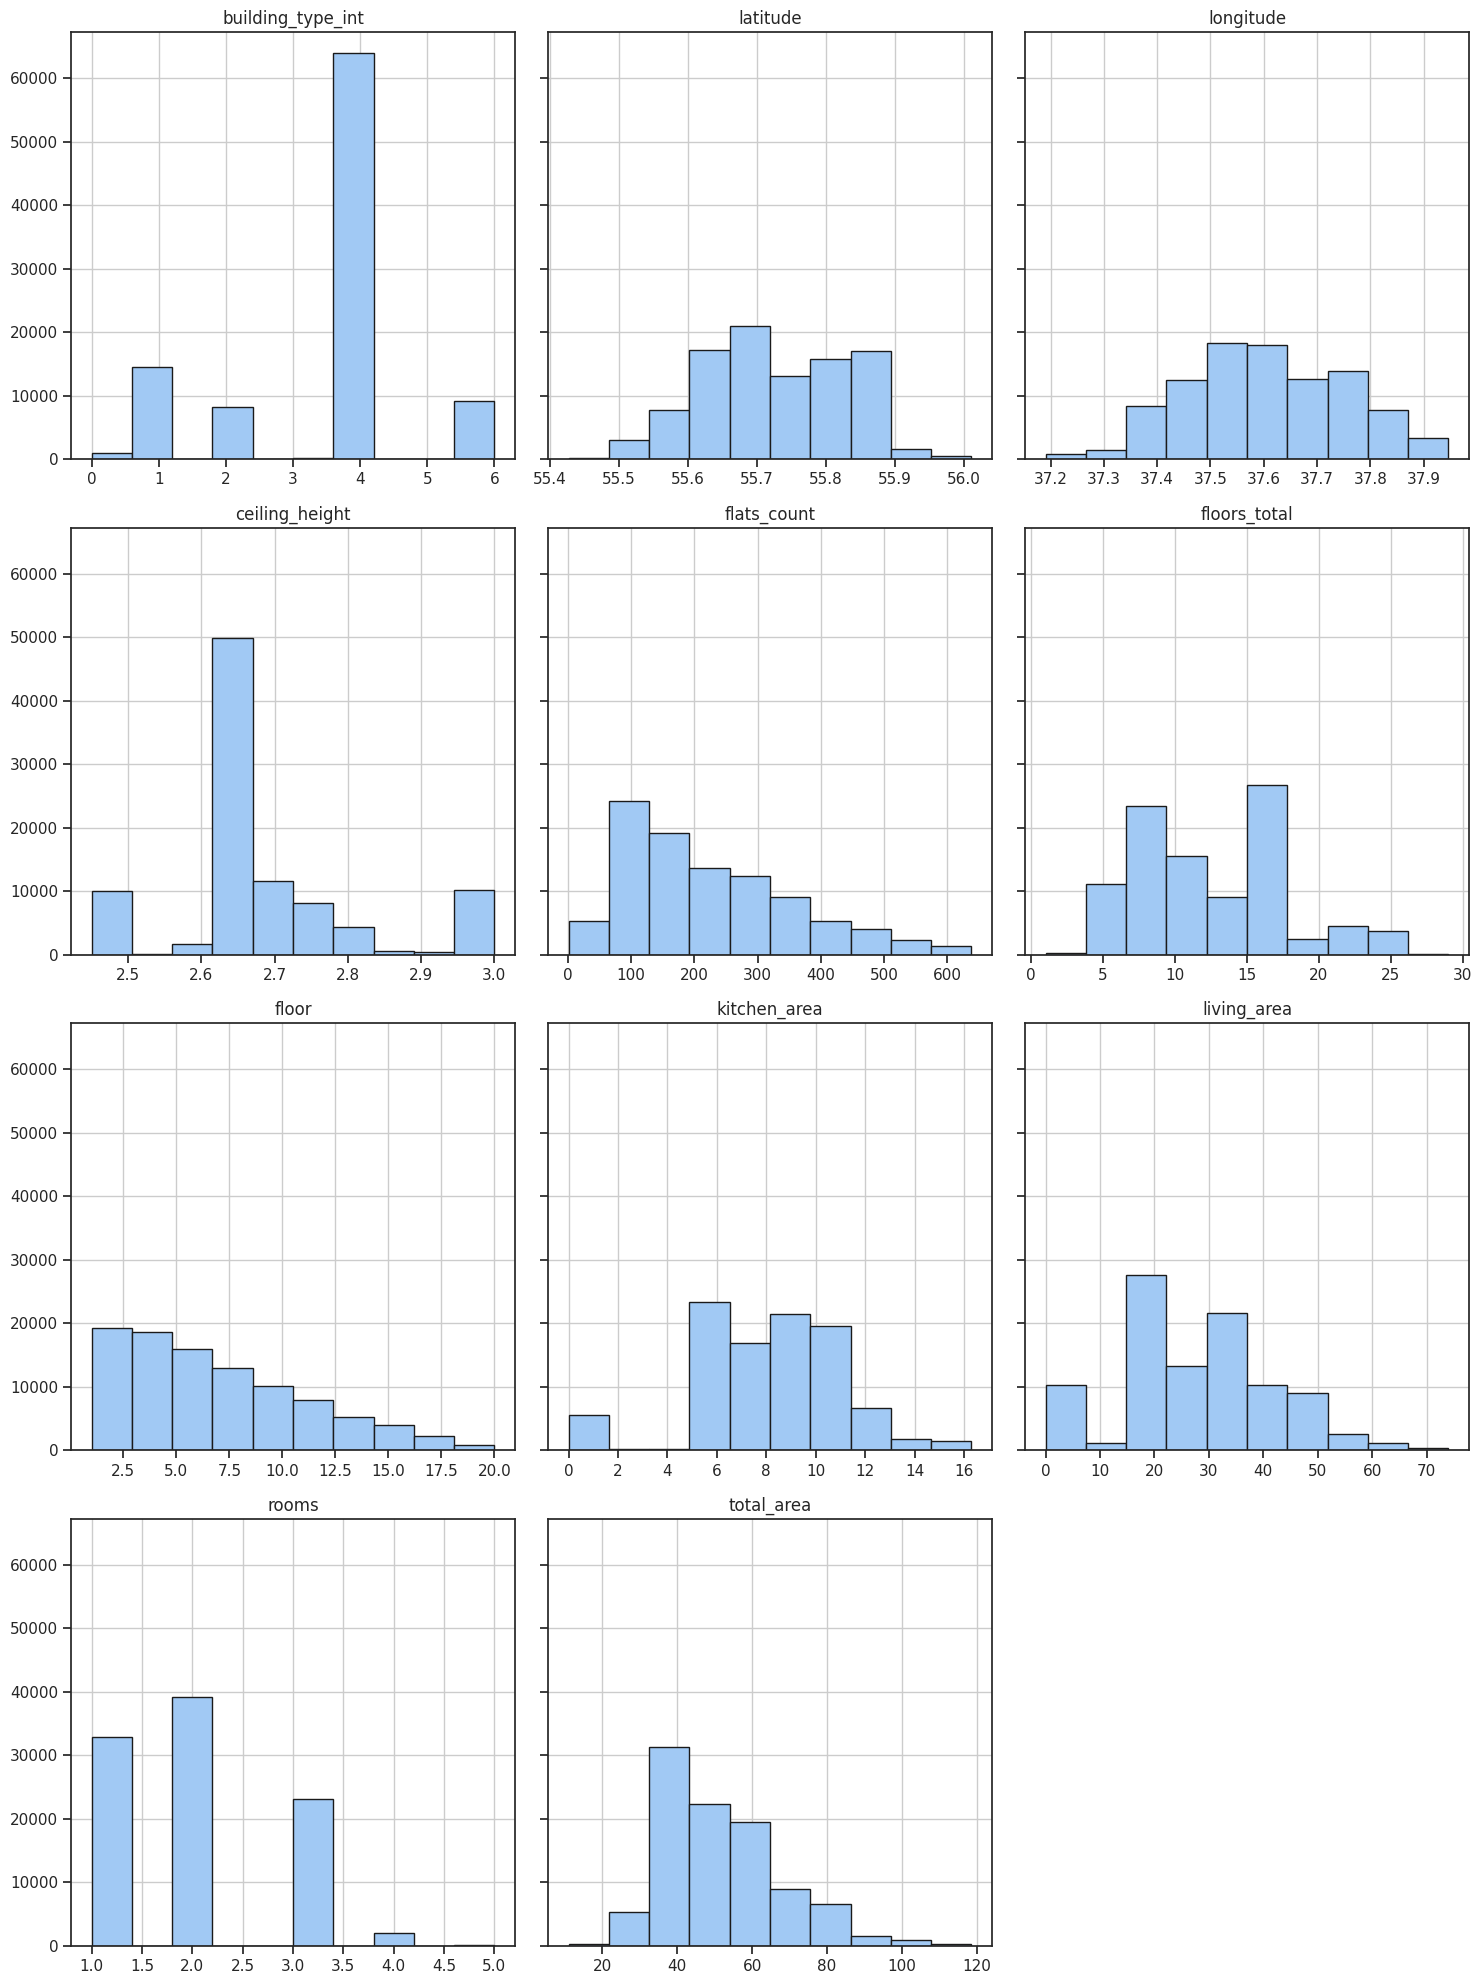

,count,mean,std,min,25%,50%,75%,max
building_type_int,97178.0,3.526755,1.416711,0.000000,4.000000,4.000000,4.000000,6.000000
latitude,97178.0,55.728495,0.103429,55.427238,55.648911,55.717884,55.814211,56.011032
longitude,97178.0,37.604187,0.148815,37.190639,37.495985,37.591732,37.722549,37.946411
ceiling_height,97178.0,2.686757,0.130452,2.450000,2.640000,2.640000,2.700000,3.000000
flats_count,97178.0,222.414487,133.349654,1.000000,111.000000,192.000000,298.000000,638.000000
floors_total,97178.0,12.998868,5.114801,1.000000,9.000000,12.000000,17.000000,29.000000
floor,97178.0,6.723096,4.501015,1.000000,3.000000,6.000000,9.000000,20.000000
kitchen_area,97178.0,8.082964,2.985974,0.000000,6.000000,8.400000,10.000000,16.300000
living_area,97178.0,27.532788,14.325563,0.000000,19.000000,28.400000,36.000000,74.000000
rooms,97178.0,1.942827,0.813515,1.000000,1.000000,2.000000,3.000000,5.000000


In [11]:
# Plotting histograms for int64/float64-features
df_nobool = features.select_dtypes(include=["int64", "float64"])
df_nobool.hist(figsize=(15, 20), edgecolor="k", sharey=True)
plt.tight_layout()
plt.show()

# Displaying descriptive stats for int64-features
display(df_nobool.describe().T)

We observe that a majority of columns are described by asymetrical or discrete distributions. 

Binary columns:

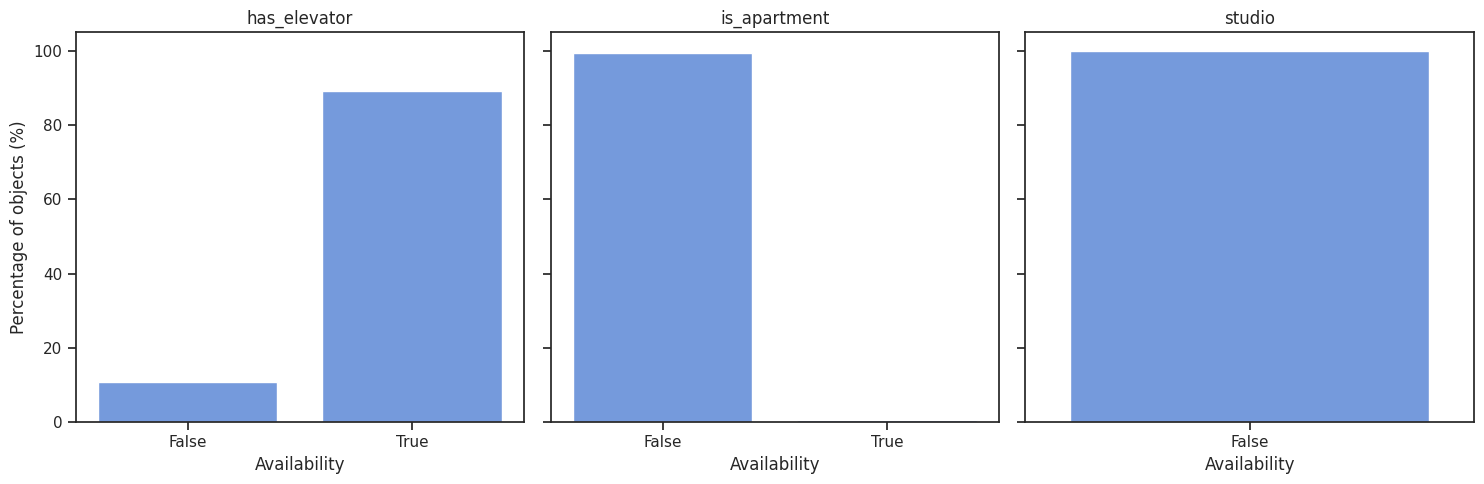

In [12]:
# Plotting frequencies barplots for bool-features
df_bool = df.select_dtypes(include="bool")
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for col, ax in zip(df_bool.columns.tolist(), axes):
    sns.countplot(x=col, data=df_bool, ax=ax, color="cornflowerblue", stat="percent")
    ax.set_xlabel("Availability")
    ax.set_ylabel("Percentage of objects (%)")
    ax.set_title(col)
plt.tight_layout()
plt.show()

We can notice that there are not studio-flats in the data whatsoever and that the most frequent objects in the data refer to flats which are not the apartments and which do have an elevator.

Lastly, we can consider the columns which affect the total area the most and visualize them depending on the number of rooms which are also an important factor:

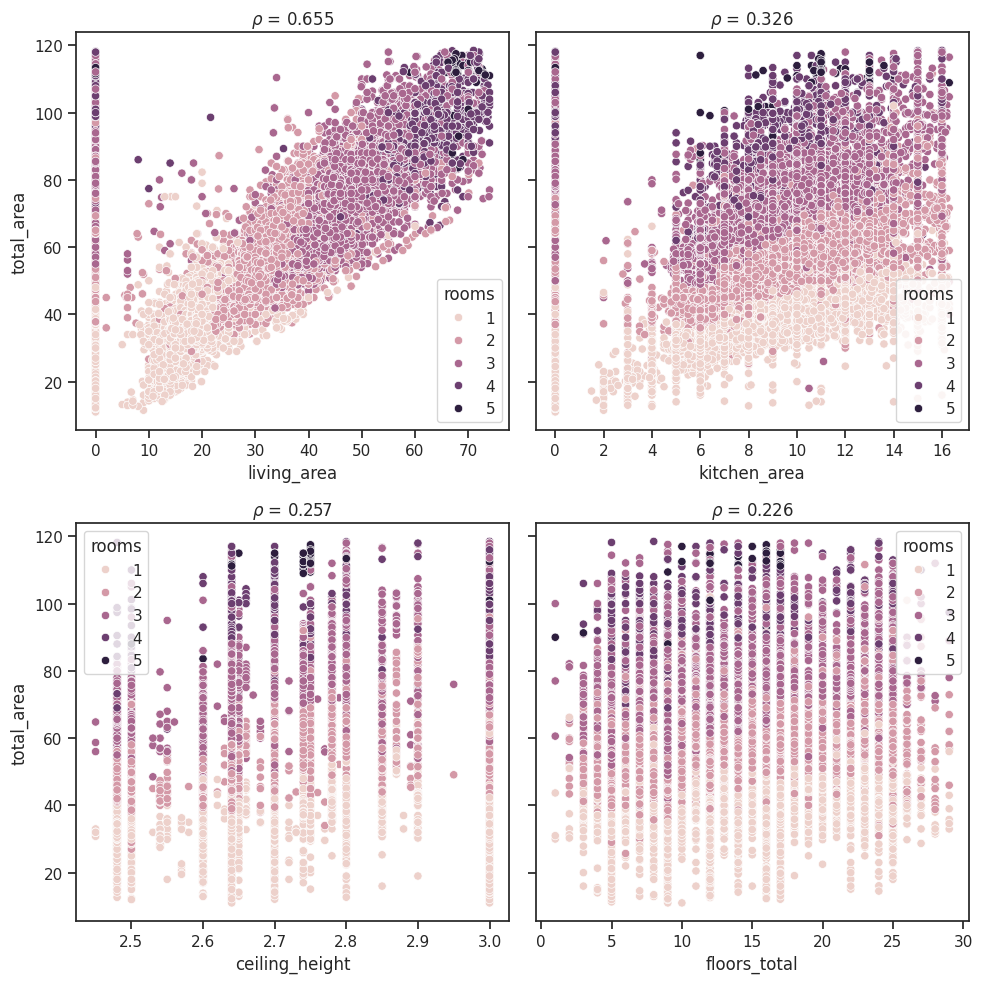

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
cols = corr_total_area_5.index[1:].tolist()
for col, ax in zip(cols, axes.flat):
    sns.scatterplot(data=df, x=col, y="total_area", hue="rooms", ax=ax)
    ax.set_title(fr"$\rho$ = {corr_total_area_5[col]:.3f}")
plt.tight_layout()
plt.show()

This graph is characterized by the presence of a color gradient which indicates higher values of the total area as the number of rooms increases. Furthermore, analyzing the top two plots, we can notice a protruding column of points at zero on the left - this is the result of null values for kitchen and living room areas being present in the data which can be either anomaly or values not specified on the website but set to zeros by the system for some reason.

##### Target analysis

Let's move on to target column. We will build a series of histograms broken down by room number, building type and elevator availability:

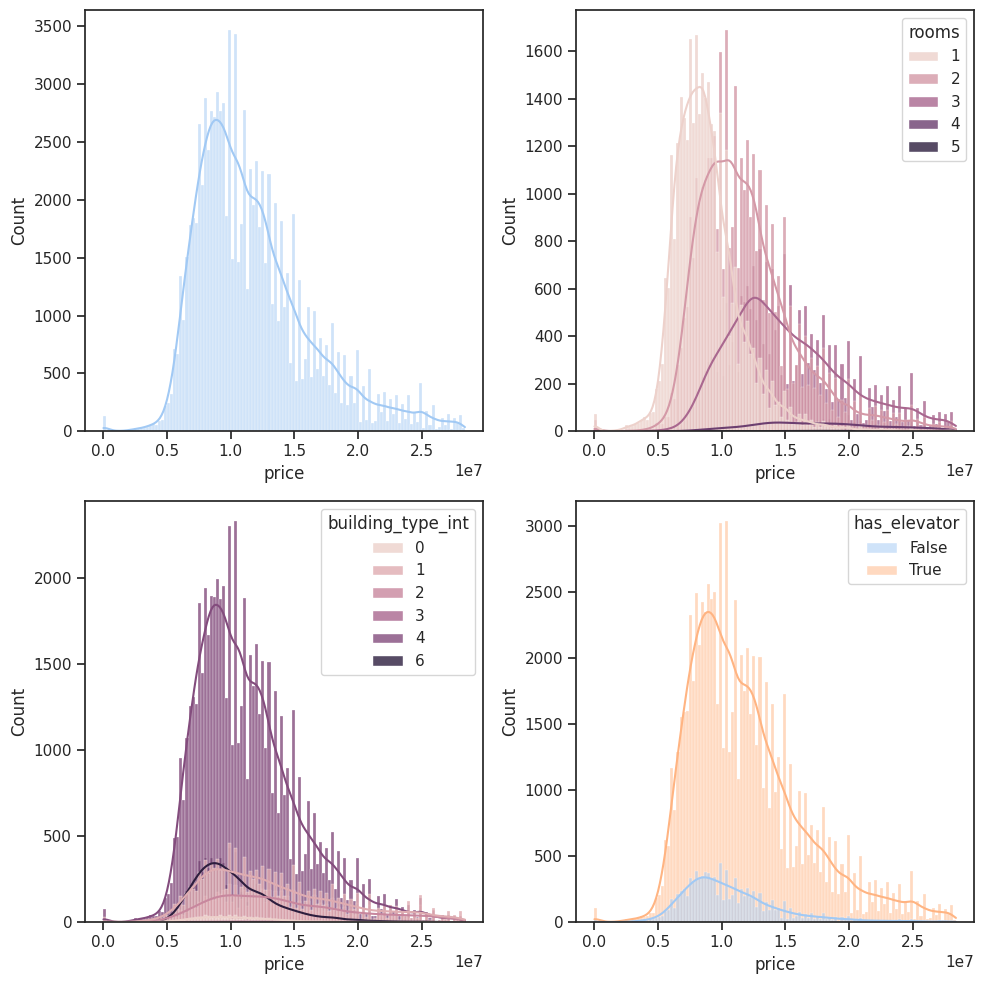

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=df, x='price', kde=True, ax=axes[0][0])
sns.histplot(data=df, x='price', hue="rooms", alpha=0.8, kde=True, ax=axes[0][1])
sns.histplot(data=df, x='price', hue="building_type_int", alpha=0.8, kde=True, ax=axes[1][0])
sns.histplot(data=df, x='price', hue="has_elevator", alpha=0.5, kde=True, ax=axes[1][1])
plt.tight_layout()
plt.show()

We can not only notice that there are more of flats with elevator than those without it but also that such flats are characterized by higher prices. Flats in buildings of types 2, 3 and 4 are those with the highest prices where flats from building type 4 predominates in terms of quantity. Prices distribution is described by a skewed curve which can be noticed by the top left plot.

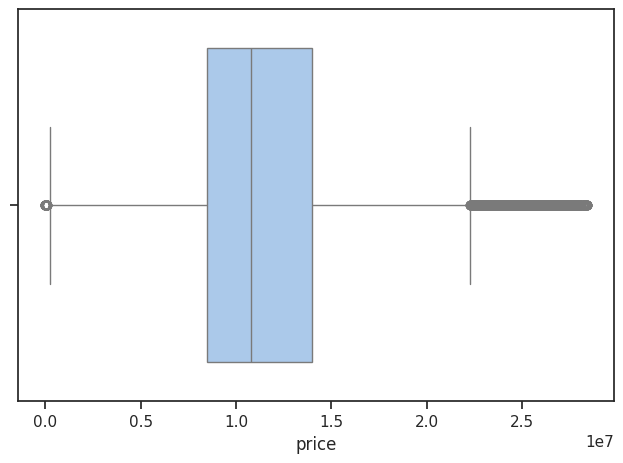

In [4]:
sns.boxplot(data=df, x='price')
plt.tight_layout()
plt.show()

One can here observe not only very high prices (which is reasonable for flat prices) but also zero ones which can be anomalies.

##### Target analysis depending on different features

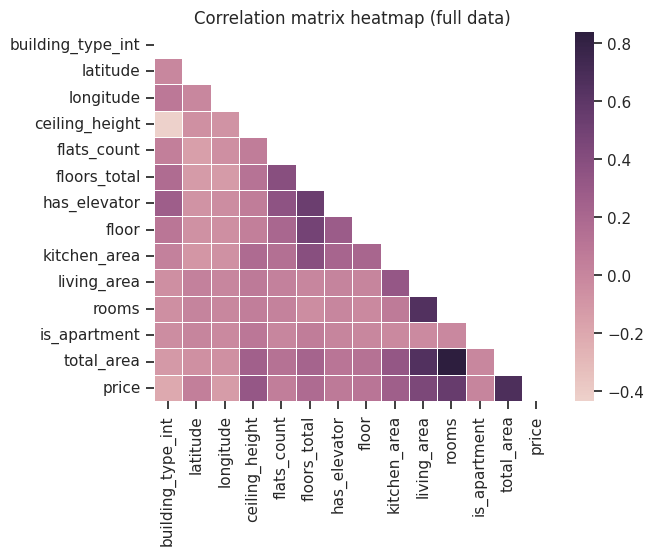

total_area        0.673892
rooms             0.551622
living_area       0.451361
ceiling_height    0.318778
kitchen_area      0.262131
Name: price, dtype: float64

In [39]:
corr_matrix = df.drop('studio', axis=1).corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
corr_heatmap = sns.heatmap(
        corr_matrix, 
        linewidth=.5,
        mask=mask,
        cmap=sns.cubehelix_palette(as_cmap=True),
    )
corr_heatmap.xaxis.tick_bottom()
corr_heatmap.yaxis.tick_left()
corr_heatmap.set(title="Correlation matrix heatmap (full data)")
plt.show()

price_factors_5 = corr_matrix["price"].abs().sort_values(ascending=False)[1:].head()
display(price_factors_5)

We can notice that such factors as total area of a flat and number of rooms have a moderate impact upon target variable which should be taken into account when building a prediction model.

We can now make joint plots of histograms and scatterplots for top-5 factors affecting the target:

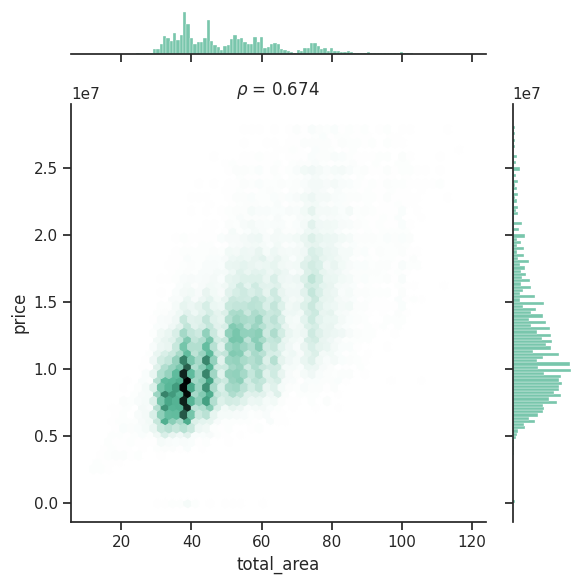

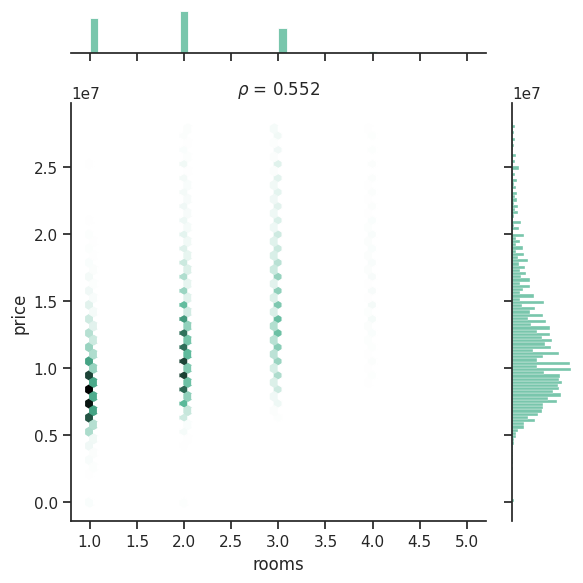

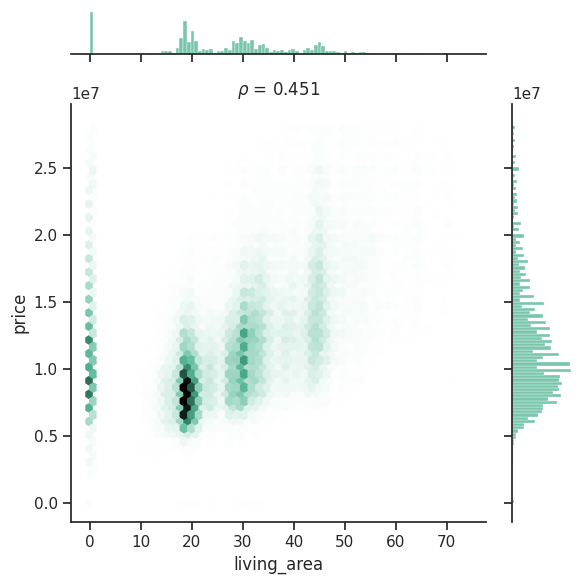

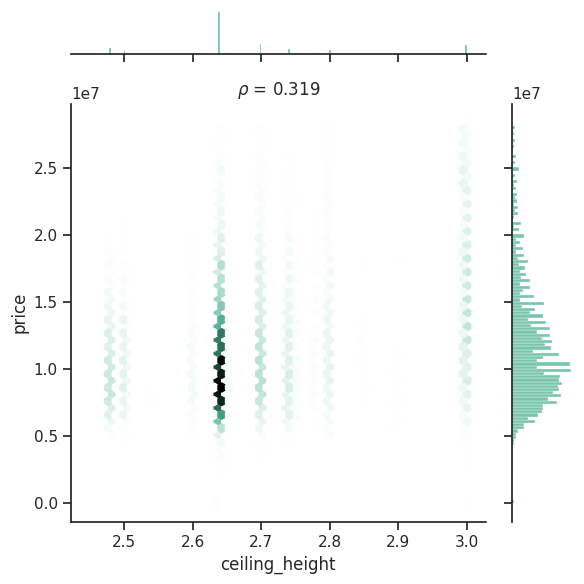

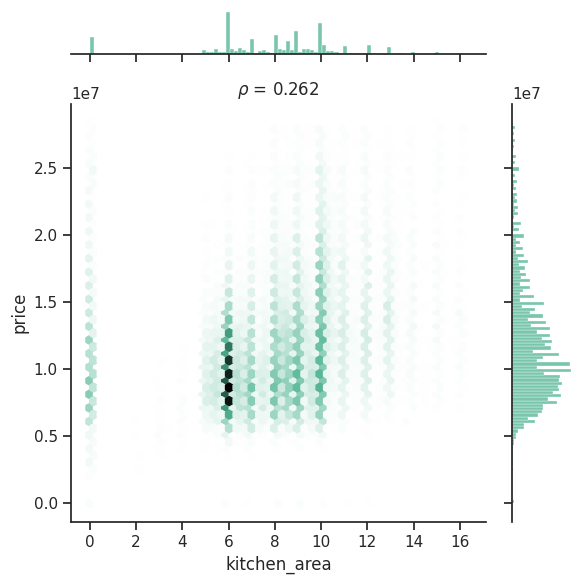

In [22]:
for col in price_factors_5.index.tolist():
    sns.jointplot(data=df, x=col, y="price", kind="hex", color="#4CB391")
    plt.title(fr"$\rho$ = {price_factors_5[col]:.3f}")
    plt.tight_layout()
    plt.show()

##### EDA conclusions

Now, after having conducted the EDA, we can summarize our key observations as follows:

1. At the beginning of the analysis, an assumption has been made about the impact of the number of rooms on the total area of a flat which could in turn affect its price. Subsequently, via studying the correlation matrices it was found that the number of rooms as well as kitchen/living room areas are pretty much correlated with the total area which is consistent not only with data but also with a common sense. Moreover, number of flats in the building as well as ceiling height have a positive correlation with this variable.

2. After adding the target to the correlation matrix, we have established that both total area and number rooms represent the two factors that affect the flat prices the most. If earlier we have found the significant influence of the rooms number on the total area, then we have additionally verified that the total area of a flat is directly proportional to the number of rooms and the prices is formed based on the total area of the flat. 

3. The factors which one needs to take into account while modeling include: total area, kitchen area, living room area, ceiling height and number of rooms.

4. The presence of very low values in the columns with price and kitchen/living room area which can either be attributed to the system error which assigned the empty values left in the form on the website zeros or to anomalies.

As a result of the EDA, duplicates and missing values have been found, since the table taken from the database represents data that has already been cleaned of such. Nevertheless, based on scatterplots and descriptive statistics one can notice very low values of prices and areas of kitchen and living room. Since the data cleaning has been carried out by a means of interquartile range, negative left bound has been computed for some columns which led to very low values having been ignored. Ideally, we need to more focus on the knowledge from the industry and thus fix the realistic bounds for features in order to avoid accounting for anomalies.

As fas as data types optimization is concerned, one can try decreasing the amount of memory taken up by the DataFrame: we can consider the bound values in integer columns and for some of them convert the data type to `int8` or `int32` which will result in reducing the memory taken up and hence more faster data processing. This is particularly important for a very large DataFrame. Furthermore, in case of string categorical columns, we could also try converting `object` type into `category` type.

##### Logging artifacts in Mlflow

In [23]:
# Starting Mlflow tracking
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [24]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

In [26]:
RUN_NAME = "eda_analysis"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id

    mlflow.log_artifact('project_template_sprint_2.ipynb', 'eda')
    mlflow.log_artifact('eda_results.md', 'eda')

#### Stage 3: Feature Engineering and Model Training

##### Manual feature engineering

We will firstly manually generate new (potentially significant features) via methods of `sklearn` library. Before starting with this, we will remove `studio` feature which is equal to `False` for all objects and will not therefore contribute any relevant information to the model.

In [4]:
features_train.drop("studio", axis=1, inplace=True)
features_test.drop("studio", axis=1, inplace=True)

In [5]:
features_train.head(3)

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area
flat_id,,,,,,,,,,,,,
128121,4,55.609226,37.592903,2.64,358,9,True,6,6.7,18.700001,1,False,32.5
117075,2,55.807060,37.772129,2.80,157,19,True,2,10.0,25.000000,2,False,46.0
7631,2,55.659382,37.771759,2.70,184,24,True,5,9.5,18.000000,1,False,40.0


Let's define which transformations we will apply to the data:

In [6]:
robust_scaler = RobustScaler()
k_bins_discretizer = KBinsDiscretizer(
    n_bins=5,
    encode="ordinal",
    strategy="uniform",
    subsample=None,
)
poly_features = PolynomialFeatures(degree=3)

We can pack all in `ColumnTransformer` class:

In [7]:
num_features = features_train.select_dtypes(include="float64").columns.tolist()
num_features

['latitude',
 'longitude',
 'ceiling_height',
 'kitchen_area',
 'living_area',
 'total_area']

In [8]:
sklearn_preprocessor = ColumnTransformer(
    transformers=[
        ("rs", robust_scaler, num_features),
        ("kbd", k_bins_discretizer, num_features),
        ("pf", poly_features, num_features),
    ],
    remainder="passthrough",
    n_jobs=-1,
)

For convenience, we will additionally pack this transformer inside the `Pipeline`:

In [9]:
sklearn_pipeline = Pipeline(
    steps=[
        ("manual_featgen", sklearn_preprocessor),
    ]
)

The next step is to transform the training and test DataFrames:

In [10]:
features_train_transformed_sklearn = sklearn_pipeline.fit_transform(features_train)
features_train_transformed_sklearn = pd.DataFrame(
    features_train_transformed_sklearn,
    columns=sklearn_pipeline.get_feature_names_out()
)
features_train_transformed_sklearn.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude ceiling_height living_area,pf__latitude ceiling_height total_area,pf__latitude kitchen_area^2,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment
0,-0.658164,0.006259,0.0,-0.425,-0.570588,-0.704545,1.0,2.0,1.0,2.0,1.0,1.0,1.0,55.609226,37.592903,2.64,6.7,18.700001,32.5,3092.386042,2090.512255,146.808363,372.581805,1039.892573,1807.299852,1413.226366,99.245268,251.872444,702.987317,1221.769352,6.969601,17.688,49.368004,85.800003,44.889997,125.290002,217.749994,349.690029,607.750025,1056.25,171965.194965,116251.768923,8163.899474,20718.985889,57827.621336,100502.54635,78588.424712,5518.952573,14006.43171,39092.580765,...,2745.316501,4771.2718,2496.298023,6967.28004,12108.908666,19445.991906,33796.508618,58737.245202,53127.281899,3730.917755,9468.616385,26427.334128,45929.856904,262.007519,664.943278,1855.886592,3225.471217,1687.545326,4710.014892,8185.854425,13145.863371,22847.087814,39707.503939,18.399746,46.696322,130.331536,226.512018,118.509598,330.765617,574.860006,923.181712,1604.460129,2788.500111,300.762974,839.442986,1458.924917,2342.923124,4071.92505,7076.874799,6539.2038,11364.925927,19751.875806,34328.125,4,358,9,True,6,1,False
1,0.540159,0.796699,2.666667,0.4,-0.2,-0.090909,3.0,3.0,3.0,3.0,1.0,1.0,1.0,55.80706,37.772129,2.8,10.0,25.0,46.0,3114.427973,2107.951482,156.259766,558.070602,1395.176506,2567.124771,1426.733734,105.76196,377.721291,944.303226,1737.517937,7.84,28.0,69.999999,128.799998,100.0,250.0,460.0,625.0,1150.0,2116.0,173807.069498,117638.575334,8720.398175,31144.2

In [11]:
features_test_transformed_sklearn = sklearn_pipeline.transform(features_test)
features_test_transformed_sklearn = pd.DataFrame(
    features_test_transformed_sklearn,
    columns=sklearn_pipeline.get_feature_names_out()
)
features_test_transformed_sklearn.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude ceiling_height living_area,pf__latitude ceiling_height total_area,pf__latitude kitchen_area^2,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment
0,-0.321711,0.769629,1.666667,-0.1,-1.670588,-0.431818,2.0,3.0,2.0,2.0,0.0,1.0,1.0,55.664772,37.765991,2.74,8.0,0.0,38.5,3098.566846,2102.235291,152.521476,445.318176,0.0,2143.093723,1426.270092,103.478816,302.12793,0.0,1453.990662,7.5076,21.92,0.0,105.49,64.0,0.0,308.0,0.0,0.0,1482.25,172481.017089,117020.448256,8490.073186,24788.534765,0.0,119294.823554,79392.999538,5760.124718,16817.882331,0.0,...,0.0,5872.076822,3562.54541,0.0,17144.749786,0.0,0.0,82509.108347,53864.503764,3907.980066,11410.160737,0.0,54911.398548,283.531958,827.83053,0.0,3983.934427,2417.023438,0.0,11631.925293,0.0,0.0,55978.640472,20.570824,60.0608,0.0,289.042602,175.360001,0.0,843.920003,0.0,0.0,4061.365014,512.0,0.0,2464.0,0.0,0.0,11858.0,0.0,0.0,0.0,57066.625,4,320,14,True,5,1,False
1,-0.087781,-0.579922,0.0,0.2775,-0.527059,-0.601364,2.0,1.0,1.0,2.0,1.0,1.0,1.0,55.703392,37.459991,2.64,9.51,19.440001,34.77,3102.867884,2086.648589,147.056961,529.739271,1082.873971,1936.806966,1403.25096,98.894381,356.244527,728.222254,1302.48392,6.969601,25.106402,51.321603,91.792805,90.440104,184.87441,330.662712,377.913621,675.928827,1208.952932,172840.266129,116233.404403,8191.571538,29508.274282,60319.753313,107886.71773,78165.838329,5508.752495,19844.028563,40564.449693,...,2858.787396,5113.170594,5037.820588,10298.13171,18419.034693,21051.07057,37651.52846,67342.779106,52565.7689

##### Auto features generation

Now we will apply another approach: automatic feature engineering via `autofeat` library:

In [12]:
autofeat_regressor = AutoFeatRegressor(
    feateng_cols=num_features,
    feateng_steps=2,
    max_gb=16,
    n_jobs=-1,
    transformations=["exp", "log"],
)

We will repeat the same data transformation steps:

In [13]:
features_train_transformed_autofeat = autofeat_regressor.fit_transform(features_train, target_train)
features_train_transformed_autofeat.head()

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,4.0,55.609226,37.592903,2.64,358.0,9.0,1.0,6.0,6.7,18.700001,1.0,0.0,32.5,201.684392,217.749994,9.190474
1,2.0,55.807060,37.772129,2.80,157.0,19.0,1.0,2.0,10.0,25.000000,2.0,0.0,46.0,202.667330,460.000000,10.720196
2,2.0,55.659382,37.771759,2.70,184.0,24.0,1.0,5.0,9.5,18.000000,1.0,0.0,40.0,202.130480,380.000000,9.959975
3,4.0,55.780632,37.527264,2.64,135.0,17.0,1.0,11.0,10.0,33.000000,2.0,0.0,55.0,202.208567,550.000000,10.579360
4,4.0,55.503551,37.599804,2.74,320.0,17.0,1.0,7.0,10.0,54.000000,3.0,0.0,84.5,201.311317,845.000000,12.156699


In [14]:
features_test_transformed_autofeat = autofeat_regressor.transform(features_test)
features_test_transformed_autofeat.head()

,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,kitchen_area,living_area,rooms,is_apartment,total_area,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,4.0,55.664772,37.765991,2.74,320.0,14.0,1.0,5.0,8.00,0.000000,1.0,0.0,38.50,202.141554,308.000000,10.002804
1,6.0,55.703392,37.459991,2.64,95.0,14.0,1.0,14.0,9.51,19.440001,1.0,0.0,34.77,201.828622,330.662712,9.368713
2,4.0,55.645000,37.367229,2.64,544.0,17.0,1.0,5.0,9.20,32.299999,2.0,0.0,53.50,201.479090,492.199990,10.506360
3,4.0,55.673431,37.572807,2.64,72.0,9.0,1.0,9.0,7.00,23.000000,2.0,0.0,38.00,201.887483,266.000000,9.603228
4,4.0,55.796234,37.720806,2.64,143.0,9.0,1.0,1.0,6.00,0.000000,2.0,0.0,44.40,202.552149,266.400000,10.014153


##### Merge

We can now join all features generated in one DataFrame:

In [15]:
autofeat_regressor.new_feat_cols_

['latitude*log(longitude)',
 'kitchen_area*total_area',
 'ceiling_height*log(total_area)']

In [16]:
features_train_full = pd.concat(
    [features_train_transformed_sklearn, 
     features_train_transformed_autofeat[autofeat_regressor.new_feat_cols_]
    ], 
    axis=1,
)
features_train_full.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,-0.658164,0.006259,0.0,-0.425,-0.570588,-0.704545,1.0,2.0,1.0,2.0,1.0,1.0,1.0,55.609226,37.592903,2.64,6.7,18.700001,32.5,3092.386042,2090.512255,146.808363,372.581805,1039.892573,1807.299852,1413.226366,99.245268,251.872444,702.987317,1221.769352,6.969601,17.688,49.368004,85.800003,44.889997,125.290002,217.749994,349.690029,607.750025,1056.25,171965.194965,116251.768923,8163.899474,20718.985889,57827.621336,100502.54635,78588.424712,5518.952573,14006.43171,39092.580765,...,6967.28004,12108.908666,19445.991906,33796.508618,58737.245202,53127.281899,3730.917755,9468.616385,26427.334128,45929.856904,262.007519,664.943278,1855.886592,3225.471217,1687.545326,4710.014892,8185.854425,13145.863371,22847.087814,39707.503939,18.399746,46.696322,130.331536,226.512018,118.509598,330.765617,574.860006,923.181712,1604.460129,2788.500111,300.762974,839.442986,1458.924917,2342.923124,4071.92505,7076.874799,6539.2038,11364.925927,19751.875806,34328.125,4,358,9,True,6,1,False,201.684392,217.749994,9.190474
1,0.540159,0.796699,2.666667,0.4,-0.2,-0.090909,3.0,3.0,3.0,3.0,1.0,1.0,1.0,55.80706,37.772129,2.8,10.0,25.0,46.0,3114.427973,2107.951482,156.259766,558.070602,1395.176506,2567.124771,1426.733734,105.76196,377.721291,944.303226,1737.517937,7.84,28.0,69.999999,128.799998,100.0,250.0,460.0,625.0,1150.0,2116.0,173807.069498,117638.575334,8720.398175,31144.279728,77860.699321,143263.68675

In [17]:
features_test_full = pd.concat(
    [features_test_transformed_sklearn, 
     features_test_transformed_autofeat[autofeat_regressor.new_feat_cols_]
    ], 
    axis=1,
)
features_test_full.head()

,rs__latitude,rs__longitude,rs__ceiling_height,rs__kitchen_area,rs__living_area,rs__total_area,kbd__latitude,kbd__longitude,kbd__ceiling_height,kbd__kitchen_area,kbd__living_area,kbd__total_area,pf__1,pf__latitude,pf__longitude,pf__ceiling_height,pf__kitchen_area,pf__living_area,pf__total_area,pf__latitude^2,pf__latitude longitude,pf__latitude ceiling_height,pf__latitude kitchen_area,pf__latitude living_area,pf__latitude total_area,pf__longitude^2,pf__longitude ceiling_height,pf__longitude kitchen_area,pf__longitude living_area,pf__longitude total_area,pf__ceiling_height^2,pf__ceiling_height kitchen_area,pf__ceiling_height living_area,pf__ceiling_height total_area,pf__kitchen_area^2,pf__kitchen_area living_area,pf__kitchen_area total_area,pf__living_area^2,pf__living_area total_area,pf__total_area^2,pf__latitude^3,pf__latitude^2 longitude,pf__latitude^2 ceiling_height,pf__latitude^2 kitchen_area,pf__latitude^2 living_area,pf__latitude^2 total_area,pf__latitude longitude^2,pf__latitude longitude ceiling_height,pf__latitude longitude kitchen_area,pf__latitude longitude living_area,...,pf__latitude kitchen_area living_area,pf__latitude kitchen_area total_area,pf__latitude living_area^2,pf__latitude living_area total_area,pf__latitude total_area^2,pf__longitude^3,pf__longitude^2 ceiling_height,pf__longitude^2 kitchen_area,pf__longitude^2 living_area,pf__longitude^2 total_area,pf__longitude ceiling_height^2,pf__longitude ceiling_height kitchen_area,pf__longitude ceiling_height living_area,pf__longitude ceiling_height total_area,pf__longitude kitchen_area^2,pf__longitude kitchen_area living_area,pf__longitude kitchen_area total_area,pf__longitude living_area^2,pf__longitude living_area total_area,pf__longitude total_area^2,pf__ceiling_height^3,pf__ceiling_height^2 kitchen_area,pf__ceiling_height^2 living_area,pf__ceiling_height^2 total_area,pf__ceiling_height kitchen_area^2,pf__ceiling_height kitchen_area living_area,pf__ceiling_height kitchen_area total_area,pf__ceiling_height living_area^2,pf__ceiling_height living_area total_area,pf__ceiling_height total_area^2,pf__kitchen_area^3,pf__kitchen_area^2 living_area,pf__kitchen_area^2 total_area,pf__kitchen_area living_area^2,pf__kitchen_area living_area total_area,pf__kitchen_area total_area^2,pf__living_area^3,pf__living_area^2 total_area,pf__living_area total_area^2,pf__total_area^3,remainder__building_type_int,remainder__flats_count,remainder__floors_total,remainder__has_elevator,remainder__floor,remainder__rooms,remainder__is_apartment,latitude*log(longitude),kitchen_area*total_area,ceiling_height*log(total_area)
0,-0.321711,0.769629,1.666667,-0.1,-1.670588,-0.431818,2.0,3.0,2.0,2.0,0.0,1.0,1.0,55.664772,37.765991,2.74,8.0,0.0,38.5,3098.566846,2102.235291,152.521476,445.318176,0.0,2143.093723,1426.270092,103.478816,302.12793,0.0,1453.990662,7.5076,21.92,0.0,105.49,64.0,0.0,308.0,0.0,0.0,1482.25,172481.017089,117020.448256,8490.073186,24788.534765,0.0,119294.823554,79392.999538,5760.124718,16817.882331,0.0,...,0.0,17144.749786,0.0,0.0,82509.108347,53864.503764,3907.980066,11410.160737,0.0,54911.398548,283.531958,827.83053,0.0,3983.934427,2417.023438,0.0,11631.925293,0.0,0.0,55978.640472,20.570824,60.0608,0.0,289.042602,175.360001,0.0,843.920003,0.0,0.0,4061.365014,512.0,0.0,2464.0,0.0,0.0,11858.0,0.0,0.0,0.0,57066.625,4,320,14,True,5,1,False,202.141554,308.000000,10.002804
1,-0.087781,-0.579922,0.0,0.2775,-0.527059,-0.601364,2.0,1.0,1.0,2.0,1.0,1.0,1.0,55.703392,37.459991,2.64,9.51,19.440001,34.77,3102.867884,2086.648589,147.056961,529.739271,1082.873971,1936.806966,1403.25096,98.894381,356.244527,728.222254,1302.48392,6.969601,25.106402,51.321603,91.792805,90.440104,184.87441,330.662712,377.913621,675.928827,1208.952932,172840.266129,116233.404403,8191.571538,29508.274282,60319.753313,107886.71773,78165.838329,5508.752495,19844.028563,40564.449693,...,10298.13171,18419.034693,21051.07057,37651.52846,67342.779106,52565.768964,3704.582681,13344.916949,27279.199408,48791.036515,261.0

##### Training a new model

In [18]:
%%time
# Instantiating a model
model = CatBoostRegressor(verbose=False)

# Launching training
model.fit(features_train_full, target_train)
print("Training finished")

Training finished
CPU times: user 1min 29s, sys: 421 ms, total: 1min 30s
Wall time: 46.9 s


In [24]:
%%time

cv_results = cross_validate(
    model,
    features_train_full,
    target_train,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

# Saving CV-results in a dict
for key, value in cv_results.items():
    cv_results[key] = round(value.mean(), 3)

# Printing CV-results
print(cv_results)

{'fit_time': 73.547, 'score_time': 0.24, 'test_score': -2406895.635}
CPU times: user 5 s, sys: 826 ms, total: 5.82 s
Wall time: 3min 29s


In [26]:
# Computing RMSE
predictions_test = model.predict(features_test_full)
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

# Adding test RMSE to metrics dict
feateng_metrics = cv_results.copy()
feateng_metrics["test_metric_rmse"] = round(rmse_test, 3)
feateng_metrics

{'fit_time': 73.547,
 'score_time': 0.24,
 'test_score': -2406895.635,
 'test_metric_rmse': 2363976.993}

In [27]:
with open('../mlflow_server/cv_results/cv_res_flats.json') as json_file:
        base_metrics = json.load(json_file)

modelling_results = pd.DataFrame(data={
    "baseline": base_metrics,
    "feateng": feateng_metrics,
})

display(modelling_results)

,baseline,feateng
fit_time,24.797,73.547
score_time,0.114,0.240
test_score,-2415562.858,-2406895.635
test_metric_rmse,NaN,2363976.993


##### Logging artifacts in Mlflow

In [31]:
pip_requirements = '../requirements.txt'
prediction = model.predict(features_test_full)
signature = mlflow.models.infer_signature(features_test_full, prediction)
input_example = features_test_full[:10]

In [32]:
model_params = model.get_params()
model_params

{'loss_function': 'RMSE', 'verbose': False}

In [33]:
RUN_NAME = "feateng_results_logging"
REGISTRY_MODEL_NAME = "feateng_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    
    # Logging feature-engineering code
    mlflow.log_artifact('project_template_sprint_2.ipynb', 'feateng_nb')

    # Logging sklearn preprocessor
    sklearn_preprocessor_info = mlflow.sklearn.log_model(
        sklearn_pipeline, 
        artifact_path="sk_preprocessor",
    )

    # Logging autofeat preprocessor
    autofeat_preprocessor_info = mlflow.sklearn.log_model(
        autofeat_regressor, 
        artifact_path="autofeat_preprocessor",
    )

    # Logging Catboost model
    model_info = mlflow.catboost.log_model( 
        registered_model_name=REGISTRY_MODEL_NAME,
        cb_model=model,
		pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        artifact_path='models'
	)

    # Logging Catboost params
    mlflow.log_params(model_params)

    # Logging metrics after feature engineering
    mlflow.log_metrics(feateng_metrics)

2024-07-07 19:36:01,082 INFO: Found credentials in environment variables.
2024/07/07 19:36:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/07/07 19:36:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://s3-student-mle-20240523-34f645dbbf/17/f31d2bef788549d381ee3a14e2715ff3/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
Successfully registered model 'feateng_model'.
2024/07/07 19:36:06 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: feateng_model, version 1
Created version '1' of model 'feateng_model'.


#### Stage 4: Feature Selection and Model Training

##### Feature selection - Method 1

Using methods like `SequentialFeatureSelection` can be quite resource-intensive, especially when we have a lot of features which is the case in our new dataset with generated features. Thus, in order to avoid waiting hours for the algorithm processing all possible feature combinations, we will take top-10 most important features from the new dataset using `feature_importances_` attribute and will hence use them for the algorithm.

In [19]:
top_features = pd.Series(
    model.feature_importances_,
    index=features_train_full.columns
).sort_values(ascending=False).head(10)
top_features

rs__latitude                              8.055300
pf__ceiling_height^2 total_area           7.353789
rs__longitude                             5.686438
pf__longitude^2                           5.265727
pf__latitude^3                            4.910933
pf__latitude^2                            4.864909
pf__latitude                              4.213708
pf__latitude ceiling_height total_area    4.002955
pf__latitude^2 longitude                  3.972853
pf__total_area                            3.232724
dtype: float64

In [20]:
features_train_top10 = features_train_full[top_features.index.tolist()]
features_test_top10 = features_test_full[top_features.index.tolist()]

In [21]:
%%time

model = CatBoostRegressor(verbose=False)

sfs = SFS(
    model, 
    k_features=5, 
    forward=True, 
    floating=False, 
    scoring='neg_root_mean_squared_error', 
    cv=2, 
    n_jobs=-1,
)

sfs = sfs.fit(features_train_top10, target_train)

top_sfs = sfs.k_feature_names_

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
display(sfs_df)

print(f"CV score (RMSE): {sfs.k_score_:.3f}")

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[-3242342.657580923, -3208669.923108274]",-3225506.290345,"(pf__ceiling_height^2 total_area,)",72441.041451,16836.367236,16836.367236
2,"(1, 4)","[-2934392.1304131965, -2899951.1340438672]",-2917171.632229,"(pf__ceiling_height^2 total_area, pf__latitude^3)",74093.823525,17220.498185,17220.498185
3,"(1, 2, 4)","[-2576591.969718261, -2556796.524951849]",-2566694.247335,"(pf__ceiling_height^2 total_area, rs__longitud...",42586.462232,9897.722383,9897.722383
4,"(1, 2, 4, 9)","[-2532623.6424623225, -2515472.253007539]",-2524047.947735,"(pf__ceiling_height^2 total_area, rs__longitud...",36898.23633,8575.694727,8575.694727
5,"(1, 2, 4, 8, 9)","[-2521134.936590412, -2506896.588095845]",-2514015.762343,"(pf__ceiling_height^2 total_area, rs__longitud...",30631.33451,7119.174247,7119.174247


CV score (RMSE): -2514015.762
CPU times: user 5.09 s, sys: 572 ms, total: 5.66 s
Wall time: 7min 54s


In [22]:
top_sfs = list(top_sfs)
top_sfs

['pf__ceiling_height^2 total_area',
 'rs__longitude',
 'pf__latitude^3',
 'pf__latitude^2 longitude',
 'pf__total_area']

In [18]:
FS_ASSETS = "fs_assets"
try:
    os.mkdir(FS_ASSETS)
except FileExistsError:
    print(f"Directory {FS_ASSETS} has already been created.")

Directory fs_assets has already been created.


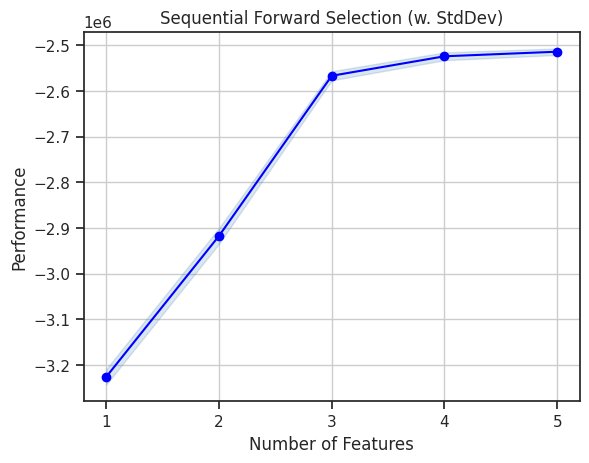

In [28]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}/sfs.png") 
plt.show()

##### Feature selection - Method 2

In [29]:
%%time

model = CatBoostRegressor(verbose=False)

sbs = SFS(
    model, 
    k_features=5, 
    forward=False, 
    floating=False, 
    scoring='neg_root_mean_squared_error', 
    cv=2, 
    n_jobs=-1,
)

sbs = sbs.fit(features_train_top10, target_train)

top_sbs = sbs.k_feature_names_

sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
display(sbs_df)

print(f"CV score (RMSE): {sbs.k_score_:.3f}")

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-2522467.5156351314, -2505965.016381921]",-2514216.266009,"(rs__latitude, pf__ceiling_height^2 total_area...",35502.261731,8251.249627,8251.249627
9,"(0, 1, 2, 3, 4, 5, 6, 8, 9)","[-2518634.2977374964, -2503717.224485377]",-2511175.761111,"(rs__latitude, pf__ceiling_height^2 total_area...",32091.492975,7458.536626,7458.536626
8,"(0, 1, 2, 3, 5, 6, 8, 9)","[-2520462.3070496786, -2501751.1867754646]",-2511106.746913,"(rs__latitude, pf__ceiling_height^2 total_area...",40253.726364,9355.560137,9355.560137
7,"(0, 1, 2, 3, 6, 8, 9)","[-2519812.695294061, -2502919.327556965]",-2511366.011426,"(rs__latitude, pf__ceiling_height^2 total_area...",36343.147406,8446.683869,8446.683869
6,"(1, 2, 3, 6, 8, 9)","[-2519534.5404782095, -2503809.9451175635]",-2511672.242798,"(pf__ceiling_height^2 total_area, rs__longitud...",33828.736578,7862.29768,7862.29768
5,"(1, 2, 6, 8, 9)","[-2520779.7881929693, -2504572.5770663423]",-2512676.18263,"(pf__ceiling_height^2 total_area, rs__longitud...",34867.000599,8103.605563,8103.605563


CV score (RMSE): -2512676.183
CPU times: user 31.8 s, sys: 1.25 s, total: 33 s
Wall time: 10min 32s


In [30]:
top_sbs = list(top_sbs)
top_sbs

['pf__ceiling_height^2 total_area',
 'rs__longitude',
 'pf__latitude',
 'pf__latitude^2 longitude',
 'pf__total_area']

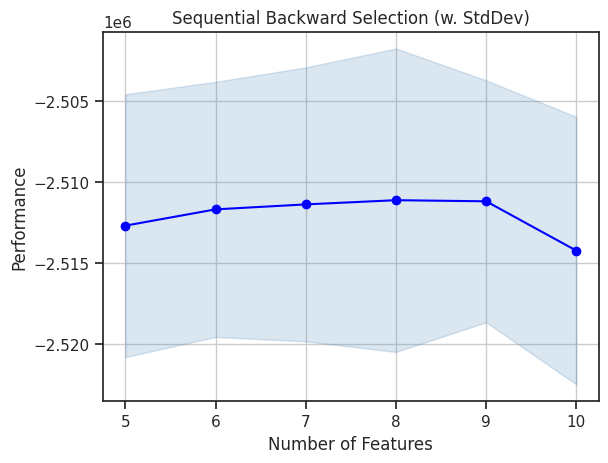

In [31]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.savefig(f"{FS_ASSETS}/sbs.png") 
plt.show()

In [64]:
sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

##### Selected features analysis

Now that we have obtained two lists of features using the two methods, we can analyze them. Let's create two lists:

* First one will contain the intersection of features
* Second one - union of features.

In [32]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

print(interc_features)
print(union_features)

['pf__total_area', 'pf__latitude^2 longitude', 'pf__ceiling_height^2 total_area', 'rs__longitude']
['pf__latitude', 'pf__latitude^3', 'rs__longitude', 'pf__latitude^2 longitude', 'pf__ceiling_height^2 total_area', 'pf__total_area']


NExt step is to train two models with the obtained features and then chose those features that results in the best scores on the test set.

##### Training models

Intersection of features:

In [34]:
%%time
# Instantiating a model
model_interc = CatBoostRegressor(verbose=False)

# Launching training
model_interc.fit(features_train_top10[interc_features], target_train)
print("Training finished")

Training finished
CPU times: user 16.4 s, sys: 165 ms, total: 16.6 s
Wall time: 8.68 s


In [35]:
%%time

cv_results_interc = cross_validate(
    model_interc,
    features_train_top10[interc_features],
    target_train,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

# Saving CV-results in a dict
for key, value in cv_results_interc.items():
    cv_results_interc[key] = round(value.mean(), 3)

# Printing CV-results
print(cv_results_interc)

{'fit_time': 17.565, 'score_time': 0.044, 'test_score': -2515834.812}
CPU times: user 422 ms, sys: 141 ms, total: 562 ms
Wall time: 50.5 s


In [37]:
predictions_test = model_interc.predict(features_test_top10[interc_features])
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

# Adding test RMSE to metrics dict
featselect_metrics_interc = cv_results_interc.copy()
featselect_metrics_interc["test_metric_rmse"] = round(rmse_test, 3)
featselect_metrics_interc

{'fit_time': 17.565,
 'score_time': 0.044,
 'test_score': -2515834.812,
 'test_metric_rmse': 2462444.478}

Union of features:

In [38]:
%%time
# Instantiating a model
model_union = CatBoostRegressor(verbose=False)

# Launching training
model_union.fit(features_train_top10[union_features], target_train)
print("Training finished")

Training finished
CPU times: user 18.1 s, sys: 208 ms, total: 18.4 s
Wall time: 9.9 s


In [39]:
%%time

cv_results_union = cross_validate(
    model_union,
    features_train_top10[union_features],
    target_train,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
)

# Saving CV-results in a dict
for key, value in cv_results_union.items():
    cv_results_union[key] = round(value.mean(), 3)

# Printing CV-results
print(cv_results_union)

{'fit_time': 17.301, 'score_time': 0.036, 'test_score': -2492952.454}
CPU times: user 458 ms, sys: 53.4 ms, total: 512 ms
Wall time: 47.6 s


In [40]:
predictions_test = model_union.predict(features_test_top10[union_features])
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

# Adding test RMSE to metrics dict
featselect_metrics_union = cv_results_union.copy()
featselect_metrics_union["test_metric_rmse"] = round(rmse_test, 3)
featselect_metrics_union

{'fit_time': 17.301,
 'score_time': 0.036,
 'test_score': -2492952.454,
 'test_metric_rmse': 2437971.125}

We can now see that the model trained on the union of features lead to the best score. Let's create some artifacts connected to this version of the model to be logged later in Mlflow:

In [41]:
with open(f"{FS_ASSETS}/features_selected.txt", "w", encoding="utf-8") as fio:
    cols = ",".join(union_features)
    fio.write(cols)

In [19]:
with open(f'{FS_ASSETS}/features_selected.txt') as txt_file:
        features_selected = txt_file.readlines()[0].split(",")
features_selected

['pf__latitude',
 'pf__latitude^3',
 'rs__longitude',
 'pf__latitude^2 longitude',
 'pf__ceiling_height^2 total_area',
 'pf__total_area']

In [53]:
featselect_metrics = featselect_metrics_union.copy()
featselect_metrics

{'fit_time': 17.301,
 'score_time': 0.036,
 'test_score': -2492952.454,
 'test_metric_rmse': 2437971.125}

In [54]:
model_featselect = model_union.copy()

##### Logging artifacts in Mlflow

In [60]:
pip_requirements = '../requirements.txt'
prediction = model_featselect.predict(features_test_top10[features_selected])
signature = mlflow.models.infer_signature(features_test_top10[features_selected], prediction)
input_example = features_test_top10[features_selected][:10]

In [61]:
model_params = model_featselect.get_params()
model_params

{'loss_function': 'RMSE', 'verbose': False}

In [63]:
RUN_NAME = "featselect_results_logging"
REGISTRY_MODEL_NAME = "featselect_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    
    # Logging feature-selection code
    mlflow.log_artifact('project_template_sprint_2.ipynb', 'feateng_nb')

    # Logging feature-selection plots
    mlflow.log_artifacts(FS_ASSETS)

    # Logging Catboost model
    model_info = mlflow.catboost.log_model( 
        registered_model_name=REGISTRY_MODEL_NAME,
        cb_model=model_featselect,
		pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        artifact_path='models'
	)

    # Logging Catboost params
    mlflow.log_params(model_params)

    # Logging metrics after feature engineering
    mlflow.log_metrics(featselect_metrics)

2024-07-10 17:52:50,467 INFO: Found credentials in environment variables.
Successfully registered model 'featselect_model'.
2024/07/10 17:52:51 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: featselect_model, version 1
Created version '1' of model 'featselect_model'.


### Stage 5: Hyperparameter Tuning and Model Training

#### Hyperparam optimization - Method 1

In [20]:
features_train_final = features_train_full[features_selected]
features_test_final = features_test_full[features_selected]

In [21]:
params = {
    'depth': np.arange(3, 8),
    'learning_rate': np.logspace(-3, -1, 5),
    'iterations': np.arange(1100, 2000, 100),
    'l2_leaf_reg': np.logspace(-2, 0, 3)
}
params

{'depth': array([3, 4, 5, 6, 7]),
 'learning_rate': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ]),
 'iterations': array([1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
 'l2_leaf_reg': array([0.01, 0.1 , 1.  ])}

In [29]:
%%time

model = CatBoostRegressor(verbose=False)

rscv = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    cv=2,
    n_iter=10,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

rscv = rscv.fit(features_train_final, target_train)

rscv_best_params = rscv.best_params_
rscv_best_score = rscv.best_score_
rscv_best_model = rscv.best_estimator_

print(f"Best hyperparameters: {rscv_best_params}")
print(f"Best score (RMSE): {rscv_best_score:.3f}")

Best hyperparameters: {'learning_rate': 0.09999999999999999, 'l2_leaf_reg': 1.0, 'iterations': 1700, 'depth': 7}
Best score (RMSE): -2497679.681
CPU times: user 34.8 s, sys: 540 ms, total: 35.3 s
Wall time: 3min 50s


In [30]:
rscv_results = pd.DataFrame(rscv.cv_results_)
best_iteration = rscv_results.iloc[rscv.best_index_]
rscv_cv_metrics = {
    "fit_time": best_iteration["mean_fit_time"],
    "score_time": best_iteration["mean_score_time"],
    "test_score": rscv_best_score,
}
rscv_cv_metrics

{'fit_time': 27.68698239326477,
 'score_time': 0.1325855255126953,
 'test_score': -2497679.681366496}

In [31]:
predictions_test = rscv_best_model.predict(features_test_final)
rmse_test = mean_squared_error(predictions_test, target_test, squared=False)

rscv_cv_metrics["test_metric_rmse"] = rmse_test
rscv_cv_metrics

{'fit_time': 27.68698239326477,
 'score_time': 0.1325855255126953,
 'test_score': -2497679.681366496,
 'test_metric_rmse': 2405297.7923220685}

In [35]:
pip_requirements = '../requirements.txt'
prediction = rscv_best_model.predict(features_test_final)
signature = mlflow.models.infer_signature(features_test_final, prediction)
input_example = features_test_final[:10]

In [37]:
RUN_NAME = "randomized_search"
REGISTRY_MODEL_NAME = "rscv_optimized_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(rscv_best_params)
    mlflow.log_metrics(rscv_cv_metrics)

    cv_info = mlflow.sklearn.log_model(rscv, artifact_path='cv')
    
    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTRY_MODEL_NAME,
            cb_model=rscv_best_model,
            signature=signature,
            input_example=input_example,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements=pip_requirements,
    )

2024-07-10 22:15:39,365 INFO: Found credentials in environment variables.
Successfully registered model 'rscv_optimized_model'.
2024/07/10 22:15:40 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: rscv_optimized_model, version 1
Created version '1' of model 'rscv_optimized_model'.


#### Hyperparam optimization - Method 2

In [43]:
def objective(trial: optuna.Trial) -> float:
    """Computes the value of the objective."""
    # Defining hyperparameter grid
    param = {
           "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
           "depth": trial.suggest_int("depth", 3, 7),
           "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 1),
           "iterations": 1700,
           "verbose": False,
    }
    # Defining the model to be used
    model = CatBoostRegressor(**param)

    # Launching k-fold cross-validation
    kf = KFold(n_splits=2)
    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(kf.split(features_train_final, target_train)):
        # Making the data splits
        train_x = features_train_final.iloc[train_index]
        train_y = target_train.iloc[train_index]
        val_x = features_train_final.iloc[val_index]
        val_y = target_train.iloc[val_index]
        
        # Training and computing validation RMSE
        model.fit(train_x, train_y)
        prediction = model.predict(val_x)
        rmse_valid = mean_squared_error(prediction, val_y, squared=False)

        metrics["rmse"].append(rmse_valid)

    # Taking median RMSE across folds
    rmse = np.median(metrics["rmse"])

    return rmse

In [49]:
RUN_NAME = "optuna_optimization"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="RMSE",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {MLFLOW_PARENT_RUN_ID: run_id}},
)

In [50]:
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "optuna_opt"

study = optuna.create_study(
    direction='minimize', 
    study_name=STUDY_NAME, 
    storage=STUDY_DB_NAME,
    sampler=optuna.samplers.TPESampler(),
    load_if_exists=True,
)
study.optimize(objective, n_trials=10, callbacks=[mlflc])

[I 2024-07-10 22:37:52,711] A new study created in RDB with name: optuna_opt
[I 2024-07-10 22:38:08,405] Trial 0 finished with value: 2538469.3475306854 and parameters: {'learning_rate': 0.025722587924307053, 'depth': 5, 'l2_leaf_reg': 0.29048413376844107}. Best is trial 0 with value: 2538469.3475306854.
[I 2024-07-10 22:38:27,875] Trial 1 finished with value: 2514132.285757213 and parameters: {'learning_rate': 0.033874320406074965, 'depth': 6, 'l2_leaf_reg': 0.24167955666743096}. Best is trial 1 with value: 2514132.285757213.
[I 2024-07-10 22:38:51,602] Trial 2 finished with value: 2496373.102479187 and parameters: {'learning_rate': 0.04652693779085352, 'depth': 7, 'l2_leaf_reg': 0.17463784764574336}. Best is trial 2 with value: 2496373.102479187.
[I 2024-07-10 22:39:04,677] Trial 3 finished with value: 2601680.1078510834 and parameters: {'learning_rate': 0.01834128016956167, 'depth': 3, 'l2_leaf_reg': 0.46398396363033456}. Best is trial 2 with value: 2496373.102479187.
[I 2024-07-10 

In [51]:
optuna_best_params = study.best_params
optuna_best_params

{'learning_rate': 0.04652693779085352,
 'depth': 7,
 'l2_leaf_reg': 0.17463784764574336}

In [52]:
optuna_best_score = study.best_value
optuna_metrics = {
    "test_score": -optuna_best_score
}
optuna_metrics

{'test_score': -2496373.102479187}

In [53]:
optuna_best_model = CatBoostRegressor(
    verbose=False,
    iterations=1700,
    **optuna_best_params,
)
optuna_best_model.fit(features_train_final, target_train)
prediction = optuna_best_model.predict(features_test_final)
rmse_test = mean_squared_error(prediction, target_test, squared=False)

optuna_metrics["test_metric_rmse"] = rmse_test
optuna_metrics

{'test_score': -2496373.102479187, 'test_metric_rmse': 2420955.9055502187}

In [54]:
model_params = optuna_best_model.get_params()
model_params

{'iterations': 1700,
 'learning_rate': 0.04652693779085352,
 'depth': 7,
 'l2_leaf_reg': 0.17463784764574336,
 'loss_function': 'RMSE',
 'verbose': False}

In [56]:
pip_requirements = '../requirements.txt'
prediction = optuna_best_model.predict(features_test_final)
signature = mlflow.models.infer_signature(features_test_final, prediction)
input_example = features_test_final[:10]

In [57]:
REGISTRY_MODEL_NAME = "optuna_optimized_model"
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    
    run_id = run.info.run_id
    mlflow.log_params(model_params)
    mlflow.log_metrics(optuna_metrics)

    model_info = mlflow.catboost.log_model( 
            registered_model_name=REGISTRY_MODEL_NAME,
            cb_model=optuna_best_model,
            signature=signature,
            input_example=input_example,
            await_registration_for=60,
            artifact_path='models',
            pip_requirements=pip_requirements,
    )

Successfully registered model 'optuna_optimized_model'.
2024/07/10 22:48:54 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: optuna_optimized_model, version 1
Created version '1' of model 'optuna_optimized_model'.
